Deep Temporal Clustering

In [192]:
# !git clone https://github.com/FlorentF9/DeepTemporalClustering.git

In [193]:
# cd DeepTemporalClustering/

In [194]:
# !pip install -r requirements.txt

In [195]:
def plot_representatives(rep_groups , figsize =(5,10)):
    l = len(rep_groups[0])
    L = len(rep_groups)
    fig, axs = plt.subplots(l,L, figsize=figsize,sharey=True,sharex=True)
    fig.tight_layout()
    for j,reps in enumerate(rep_groups):
        for i,rep in enumerate(reps):
            axs[i,j].plot(rep[:,0],rep[:,1])
    fig.show()

In [196]:
def plot_autoencoder_by_time(orig_list,pred_list , figsize =(10,15)):
    rows = len(orig_list)
    timesteps = orig_list[0].shape[0]
    features = orig_list[0].shape[1]
    fig, axs = plt.subplots(rows,features, figsize=figsize,sharey=True,sharex=True)
    fig.tight_layout()
    for j in range(features):
      for i,_ in enumerate(orig_list):
          data = np.zeros((timesteps,2))
          data[:,0] = pred_list[i][:,j]
          data[:,1] = orig_list[i][:,j]
          idx = [i for i in range(len(data))]
          axs[i,j].plot(idx,data)
    fig.show()

In [197]:
#TODO replace in TSClusteringLayer.py - 
# from tensorflow.keras.layers import Layer, InputSpec
from DeepTemporalClustering import DTC

In [198]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
import os
import matplotlib.pyplot as plt

In [199]:
save_dir = 'results/tmp'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [200]:
wells_to_genetype_dict = {
  **dict.fromkeys(['D2','D3','D4','G5','G6','G7'], "control"),
  **dict.fromkeys(['D5','D6','D7'], "Grb2"),
  **dict.fromkeys(['F2','F3','F4'], "Gab1"),
  **dict.fromkeys(['G2','G3','G4'], "MET+Gab1"),
  **dict.fromkeys(['E5','E6',"E7"], "MET+Grb2")
}

In [201]:
x = np.load('/content/features_All32.npy')
traj = x[:,:,:2]
traj.shape

(4600, 32, 2)

In [202]:
y = np.load('/content/labels_All32.npy')
y2treat = pd.Series(y).map(wells_to_genetype_dict)
le = LabelEncoder()
le.fit(list(wells_to_genetype_dict.values()))
y_lbl = le.transform(y2treat.values)
y = None


In [203]:
scaler = StandardScaler()
traj_norm = scaler.fit_transform(traj.reshape(-1, traj.shape[-1])).reshape(traj.shape)
# y = np.load('/content/y_exp.npy')
X_train = traj_norm.copy()
# y = y_lbl

In [204]:
n_clusters = 3

In [205]:
# Set default values
pretrain_optimizer = 'adam'
# Instantiate model
dtc = DTC(n_clusters=n_clusters,
          input_dim=X_train.shape[-1],
          timesteps=X_train.shape[1],
          n_filters=128,
          kernel_size=4,
          strides=1,
          pool_size=8,
          n_units=[50, 4],
          alpha=1,
          dist_metric='cid',
          cluster_init='kmeans',
          heatmap=False)

# Initialize model
optimizer = 'adam'
dtc.initialize()
dtc.model.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_seq (InputLayer)         [(None, 32, 2)]      0           []                               
                                                                                                  
 conv1d_36 (Conv1D)             (None, 32, 128)      1152        ['input_seq[0][0]']              
                                                                                                  
 conv1d_37 (Conv1D)             (None, 32, 128)      65664       ['conv1d_36[0][0]']              
                                                                                                  
 conv1d_38 (Conv1D)             (None, 32, 128)      65664       ['conv1d_37[0][0]']              
                                                                                           

In [206]:
dtc.pretrain(X=X_train, optimizer=pretrain_optimizer,
              epochs=50, batch_size=64,
              save_dir='results/tmp')

Pretraining...
Epoch 1/50
72/72 [==============================] - 3s 8ms/step - loss: 0.3961
Epoch 2/50
72/72 [==============================] - 1s 8ms/step - loss: 0.1797
Epoch 3/50
72/72 [==============================] - 1s 8ms/step - loss: 0.1355
Epoch 4/50
72/72 [==============================] - 1s 8ms/step - loss: 0.1193
Epoch 5/50
72/72 [==============================] - 1s 7ms/step - loss: 0.1108
Epoch 6/50
72/72 [==============================] - 1s 7ms/step - loss: 0.1057
Epoch 7/50
72/72 [==============================] - 1s 8ms/step - loss: 0.1010
Epoch 8/50
72/72 [==============================] - 1s 7ms/step - loss: 0.0979
Epoch 9/50
72/72 [==============================] - 1s 7ms/step - loss: 0.0969
Epoch 10/50
72/72 [==============================] - 1s 7ms/step - loss: 0.0930
Epoch 11/50
72/72 [==============================] - 1s 8ms/step - loss: 0.0914
Epoch 12/50
72/72 [==============================] - 1s 7ms/step - loss: 0.0898
Epoch 13/50
72/72 [===============

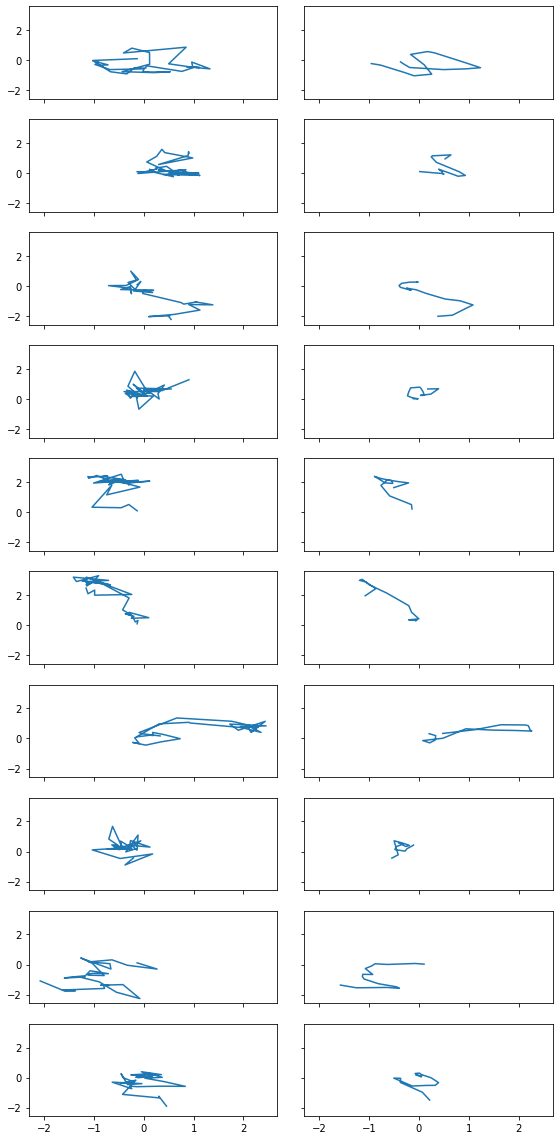

In [207]:
size = 10
# rand_idx = np.random.choice(X_train.shape[0], size, replace=False)

orig_vec = X_train[:10,:,:]

pred_vec = dtc.autoencoder.predict(orig_vec)

plot_representatives([orig_vec,pred_vec] , figsize =(8,16))

Autoencoder encodings with latent of size 8 (compression of 1/4)

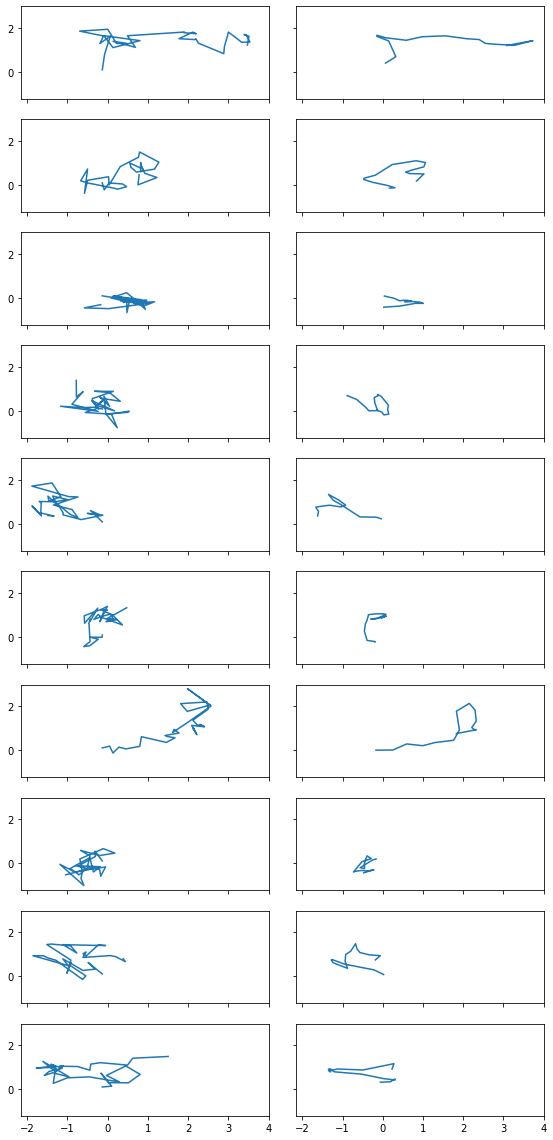

In [208]:
size = 10
rand_idx = np.random.choice(X_train.shape[0], size, replace=False)

orig_vec = X_train[rand_idx,:,:]

pred_vec = dtc.autoencoder.predict(orig_vec)

plot_representatives([orig_vec,pred_vec] , figsize =(8,16))

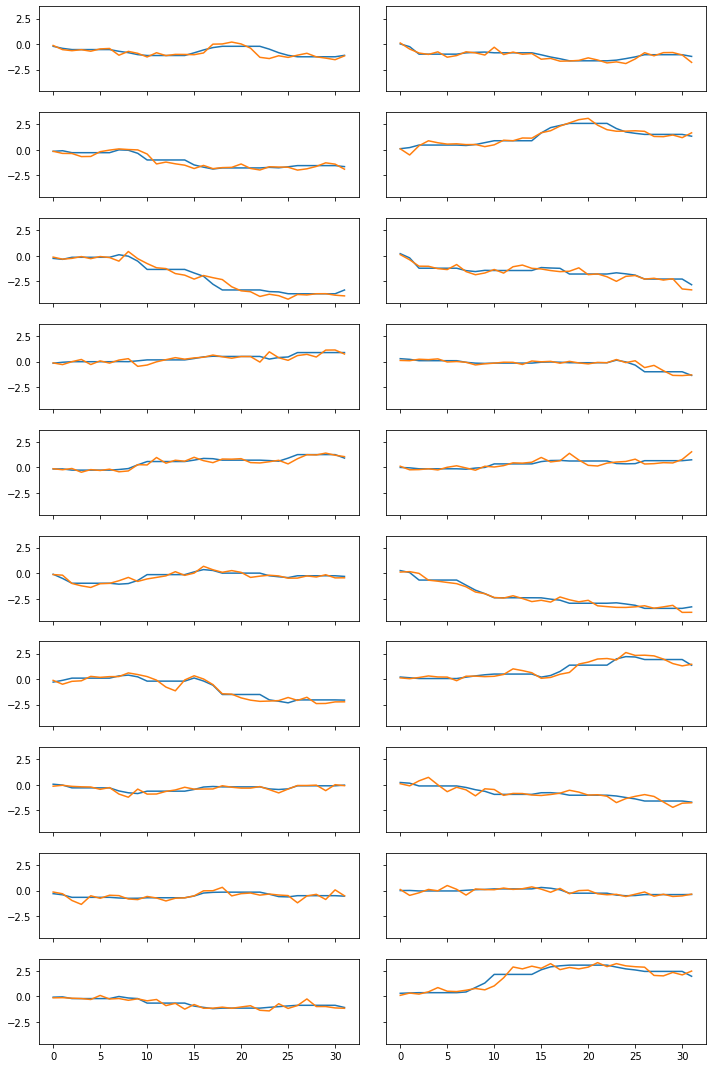

In [209]:
size = 10
rand_idx = np.random.choice(X_train.shape[0], size, replace=False)

orig_vec = X_train[rand_idx,:,:]

pred_vec = dtc.autoencoder.predict(orig_vec)

plot_autoencoder_by_time(orig_vec,pred_vec)

In [210]:
latent = dtc.encode(X_train[:,:,:])

In [211]:
latent = latent.reshape(latent.shape[0],latent[0,:,:].flatten().shape[0])

In [212]:
latent.shape

(4600, 16)

In [213]:
from sklearn.manifold import TSNE

latent_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(latent)

In [214]:
le.inverse_transform([0,1,2,3,4])

array(['Gab1', 'Grb2', 'MET+Gab1', 'MET+Grb2', 'control'], dtype='<U8')

TSNE of the latent layer with coloring of different treatments

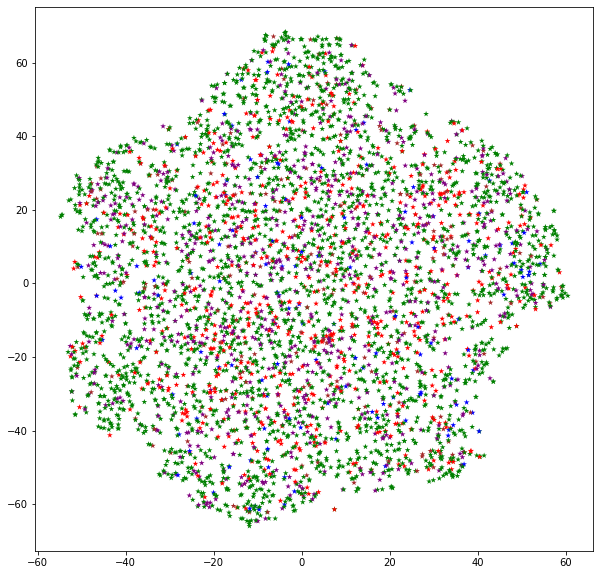

In [215]:
color_options = ['red','blue','purple','brown','green', 'pink', 'black']
colors = [color_options[i] for i in y_lbl]
plt.subplots(figsize = (10,10))
plt.scatter(latent_embedded[:, 0], latent_embedded[:, 1], c = colors , marker='*', linewidths=0)

In [216]:
y_pred =  dtc.predict(X_train)

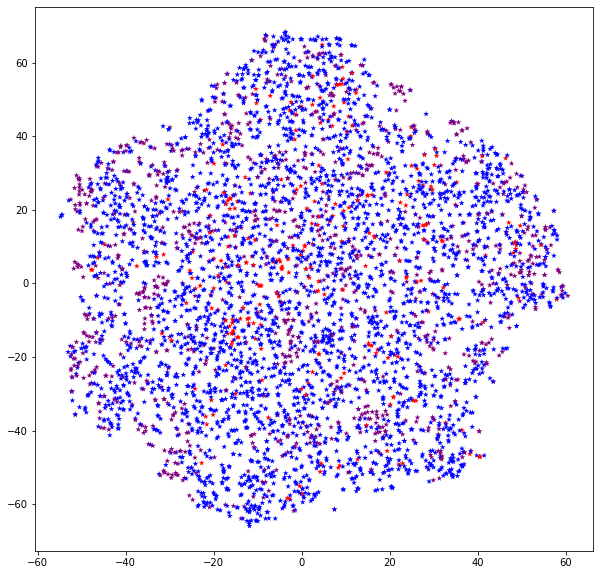

In [217]:
color_options = ['red','blue','purple','brown','green', 'pink', 'black']
colors = [color_options[i] for i in y_pred]
plt.subplots(figsize = (10,10))
plt.scatter(latent_embedded[:, 0], latent_embedded[:, 1], c = colors , marker='*', linewidths=0)

In [218]:
dtc.compile(gamma=1, optimizer=optimizer, initial_heatmap_loss_weight=0.1, final_heatmap_loss_weight=0.9)
dtc.init_cluster_weights(X_train)
y_train = None
X_val, y_val = None, None
# Fit model
dtc.fit(X_train, y_train, X_val, y_val, 100, 10, 100, 64, 0.001, 5, 8, 'results/tmp')

Initializing cluster...
Done!
Training for 100 epochs.
Evaluating every 10 and saving model every 100 epochs.
epoch 0
[Train] - Lr=0.074060, Lc=0.066884 - total loss=0.140944
Saved model to: results/tmp/DTC_model_0.h5
epoch 10
[Train] - Lr=0.104184, Lc=0.025712 - total loss=0.129896
epoch 20
[Train] - Lr=0.106997, Lc=0.017822 - total loss=0.124819
epoch 30
[Train] - Lr=0.101843, Lc=0.012777 - total loss=0.114619
epoch 40
[Train] - Lr=0.102109, Lc=0.014651 - total loss=0.116760
epoch 50
[Train] - Lr=0.097098, Lc=0.010124 - total loss=0.107223
epoch 60
[Train] - Lr=0.106995, Lc=0.013698 - total loss=0.120693
epoch 70
[Train] - Lr=0.095397, Lc=0.008222 - total loss=0.103619
epoch 80
[Train] - Lr=0.101457, Lc=0.009956 - total loss=0.111413
epoch 90
[Train] - Lr=0.109714, Lc=0.013354 - total loss=0.123067
Saving model to: results/tmp/DTC_model_final.h5


In [219]:
y_pred =  dtc.predict(X_train)

In [220]:
latent_a = dtc.encode(X_train[:,:,:])
latent_a = latent_a.reshape(latent_a.shape[0],latent_a[0,:,:].flatten().shape[0])
latent_embedded_a = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(latent_a)

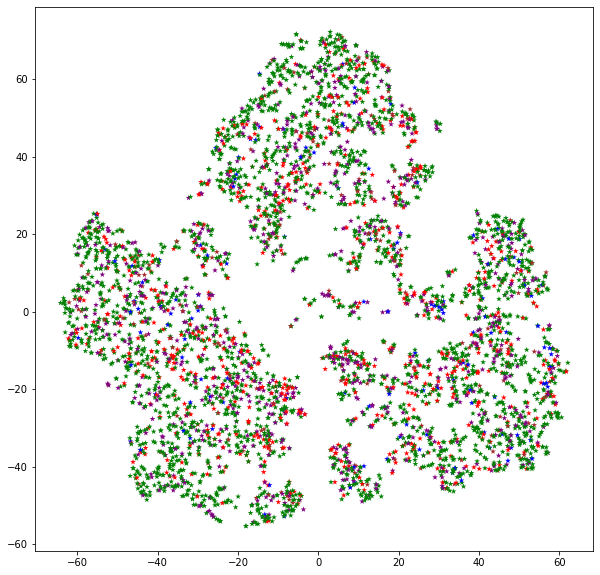

In [221]:
color_options = ['red','blue','purple','brown','green', 'pink', 'black']
colors = [color_options[i] for i in y_lbl]
plt.subplots(figsize = (10,10))
plt.scatter(latent_embedded_a[:, 0], latent_embedded_a[:, 1], c = colors , marker='*', linewidths=0)

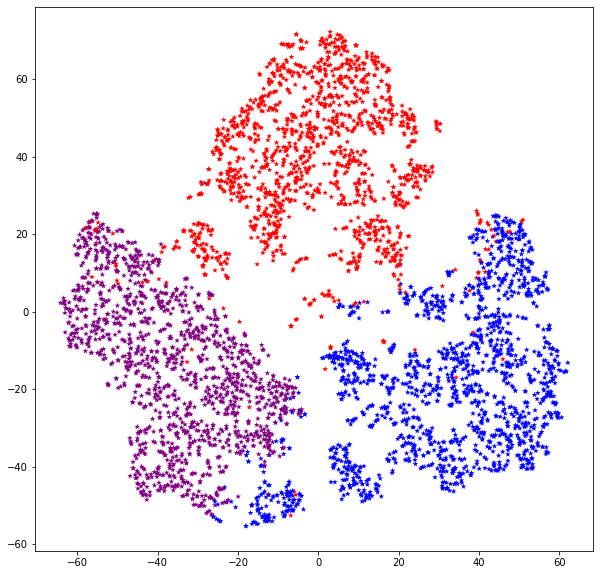

In [222]:
color_options = ['red','blue','purple','brown','green', 'pink', 'black']
colors = [color_options[i] for i in y_pred]
plt.subplots(figsize = (10,10))
plt.scatter(latent_embedded_a[:, 0], latent_embedded_a[:, 1], c = colors , marker='*', linewidths=0)

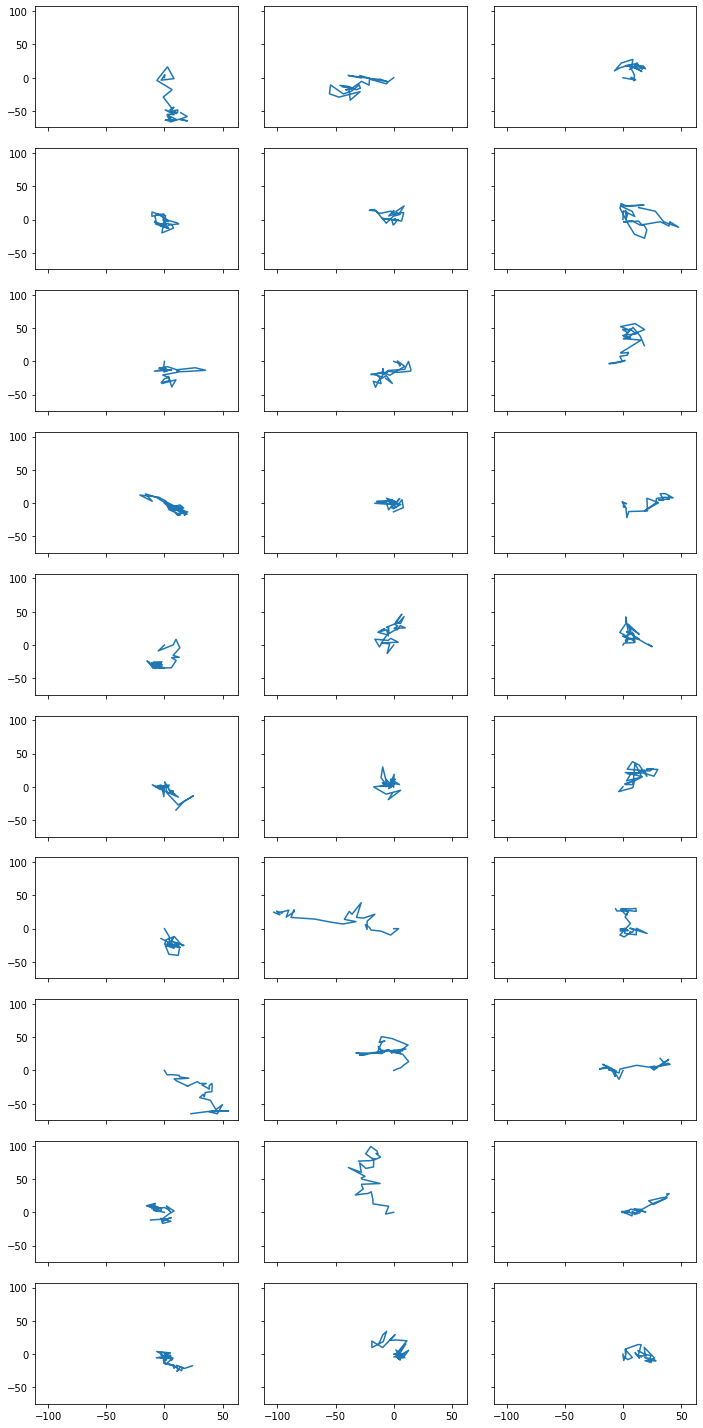

In [223]:
rep_list = []
size = 10
for i in range(n_clusters):
  cluster_vec = x[np.where(np.isin(y_pred,[i]))]
  cluster_list = cluster_vec[np.random.choice(cluster_vec.shape[0], size, replace=False)]
  rep_list.append(cluster_list)

plot_representatives(rep_list,figsize = (10,20))

In [224]:
pd.Series(y_lbl).value_counts()

4    2817
2     782
0     654
3     210
1     137
dtype: int64

In [225]:
le.classes_

array(['Gab1', 'Grb2', 'MET+Gab1', 'MET+Grb2', 'control'], dtype='<U8')

Representations of different treatments in each cluster

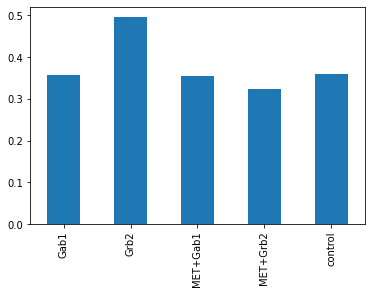

In [226]:
cluster0_freq = {}
for i in range(5):
  treat_well = dtc.predict(X_train[np.where(np.isin(y_lbl,i))])
  cluster0_freq[le.inverse_transform([i])[0]] = pd.Series(treat_well).value_counts(normalize=True).sort_index()[1]
pd.Series(cluster0_freq).plot.bar()

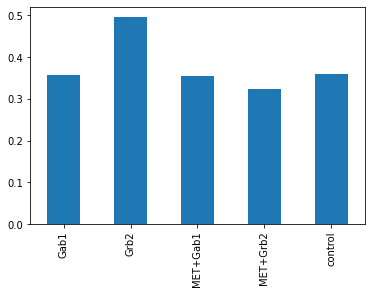

In [227]:
cluster1_freq = {}
for i in range(5):
  treat_well = dtc.predict(X_train[np.where(np.isin(y_lbl,i))])
  cluster1_freq[le.inverse_transform([i])[0]] = pd.Series(treat_well).value_counts(normalize=True).sort_index()[1]
pd.Series(cluster1_freq).plot.bar()

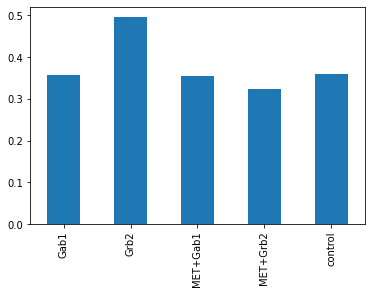

In [228]:
cluster2_freq = {}
for i in range(5):
  treat_well = dtc.predict(X_train[np.where(np.isin(y_lbl,i))])
  cluster2_freq[le.inverse_transform([i])[0]] = pd.Series(treat_well).value_counts(normalize=True).sort_index()[1]
pd.Series(cluster2_freq).plot.bar()

In [229]:
%%shell
jupyter nbconvert --to html /content/DTC.ipynb

[NbConvertApp] Converting notebook /content/DTC.ipynb to html
[NbConvertApp] Writing 1676681 bytes to /content/DTC.html
